# 05 — BERTimbau Fine-tuning

Fine-tuning do **BERTimbau** (`neuralmind/bert-base-portuguese-cased`) para classificação de sentimento ternário.

**Configuração:**
- Subsample estratificado de 30K para treino (viabilizar MPS/CPU)
- max_length=128, epochs=3, lr=2e-5, batch_size=16
- MPS backend (Apple Silicon), fp32
- weight_decay=0.01, avaliação por época
- Val e teste completos para avaliação justa

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

from src.config import (
    BERT_MODEL_NAME, BERT_MAX_LENGTH, BERT_EPOCHS, BERT_LR,
    BERT_BATCH_SIZE, BERT_WEIGHT_DECAY, MODELS_DIR, SEED,
    TEXT_COLUMN, SENTIMENT_LABELS,
)
from src.data_loader import carregar_splits
from src.evaluation import calcular_metricas, salvar_metricas, plotar_matriz_confusao
from src.utils import set_seed, get_device, timer

set_seed()
device = get_device()
print(f"Device: {device}")

Device: mps


## 1. Carregar Dados

In [2]:
from sklearn.model_selection import train_test_split as sklearn_split

df_train, df_val, df_test = carregar_splits()

# Subsample estratificado do treino para viabilizar fine-tuning em MPS/CPU
BERT_TRAIN_SUBSET = 30_000

if len(df_train) > BERT_TRAIN_SUBSET:
    df_train_bert, _ = sklearn_split(
        df_train,
        train_size=BERT_TRAIN_SUBSET,
        random_state=SEED,
        stratify=df_train["label"],
    )
    print(f"Subsample treino: {len(df_train_bert):,} de {len(df_train):,}")
else:
    df_train_bert = df_train

# Usar texto original (BERT faz sua própria tokenização)
df_train_bert["text"] = df_train_bert[TEXT_COLUMN].fillna("")
df_val["text"] = df_val[TEXT_COLUMN].fillna("")
df_test["text"] = df_test[TEXT_COLUMN].fillna("")

# Converter para HF Dataset
ds_train = Dataset.from_pandas(df_train_bert[["text", "label"]].reset_index(drop=True))
ds_val = Dataset.from_pandas(df_val[["text", "label"]].reset_index(drop=True))
ds_test = Dataset.from_pandas(df_test[["text", "label"]].reset_index(drop=True))

print(f"Treino BERT: {len(ds_train):,} | Val: {len(ds_val):,} | Teste: {len(ds_test):,}")

Splits carregados: treino=90,368 | val=19,365 | teste=19,365
Subsample treino: 30,000 de 90,368
Treino BERT: 30,000 | Val: 19,365 | Teste: 19,365


## 2. Tokenização

In [3]:
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

BERT_MAX_LEN = 128  # Reduzido de 256 para acelerar treino

def tokenize_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=BERT_MAX_LEN,
    )

with timer("Tokenização"):
    ds_train = ds_train.map(tokenize_fn, batched=True, batch_size=1000)
    ds_val = ds_val.map(tokenize_fn, batched=True, batch_size=1000)
    ds_test = ds_test.map(tokenize_fn, batched=True, batch_size=1000)

# Configurar formato PyTorch
ds_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
ds_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])
ds_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/19365 [00:00<?, ? examples/s]

Map:   0%|          | 0/19365 [00:00<?, ? examples/s]

⏱ Tokenização: 3.8s


## 3. Modelo

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL_NAME,
    num_labels=len(SENTIMENT_LABELS),
)

# Label mapping
model.config.id2label = {i: l for i, l in enumerate(SENTIMENT_LABELS)}
model.config.label2id = {l: i for i, l in enumerate(SENTIMENT_LABELS)}

print(f"Parâmetros: {sum(p.numel() for p in model.parameters()):,}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parâmetros: 108,925,443


## 4. Training Arguments

In [5]:
output_dir = str(MODELS_DIR / "bert_sentiment")

# Detectar se deve usar fp16
use_fp16 = device.type == "cuda"  # MPS não suporta fp16 bem

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=BERT_EPOCHS,
    learning_rate=BERT_LR,
    per_device_train_batch_size=BERT_BATCH_SIZE,
    per_device_eval_batch_size=BERT_BATCH_SIZE * 2,
    weight_decay=BERT_WEIGHT_DECAY,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,
    fp16=use_fp16,
    logging_steps=100,
    seed=SEED,
    report_to="none",
)

print(f"Epochs: {BERT_EPOCHS}, LR: {BERT_LR}, Batch: {BERT_BATCH_SIZE}")
print(f"FP16: {use_fp16}")

Epochs: 3, LR: 2e-05, Batch: 16
FP16: False


In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics,
)

## 5. Treinamento

In [7]:
with timer("Fine-tuning BERTimbau"):
    train_result = trainer.train()

print(f"\nMétricas de treino: {train_result.metrics}")

/Users/devsquad/Library/Caches/pypoetry/virtualenvs/pln-sentiments-_Ad7U3Oz-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.377600,0.383167,0.859592,0.843060
2,0.328700,0.400550,0.859747,0.840631
3,0.255300,0.441104,0.857578,0.851070


/Users/devsquad/Library/Caches/pypoetry/virtualenvs/pln-sentiments-_Ad7U3Oz-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


/Users/devsquad/Library/Caches/pypoetry/virtualenvs/pln-sentiments-_Ad7U3Oz-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


⏱ Fine-tuning BERTimbau: 63min 34.3s

Métricas de treino: {'train_runtime': 3814.2614, 'train_samples_per_second': 23.596, 'train_steps_per_second': 1.475, 'total_flos': 5920051898880000.0, 'train_loss': 0.3317308585272895, 'epoch': 3.0}


## 6. Avaliação no Teste

In [8]:
predictions = trainer.predict(ds_test)
y_test_pred = np.argmax(predictions.predictions, axis=-1)
y_test = np.array(df_test["label"].tolist())

metricas = calcular_metricas(y_test, y_test_pred, "BERTimbau")
salvar_metricas(metricas)

/Users/devsquad/Library/Caches/pypoetry/virtualenvs/pln-sentiments-_Ad7U3Oz-py3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)



Resultados: BERTimbau
Accuracy:  0.8538
F1 (weighted): 0.8464
Precision: 0.8415
Recall:    0.8538

Classification Report:
              precision    recall  f1-score   support

    negativo       0.87      0.90      0.89      5066
      neutro       0.49      0.37      0.42      2402
    positivo       0.90      0.93      0.92     11897

    accuracy                           0.85     19365
   macro avg       0.75      0.73      0.74     19365
weighted avg       0.84      0.85      0.85     19365

Métricas salvas em /Users/devsquad/PLN-sentiments/models/metricas_bertimbau.json


PosixPath('/Users/devsquad/PLN-sentiments/models/metricas_bertimbau.json')

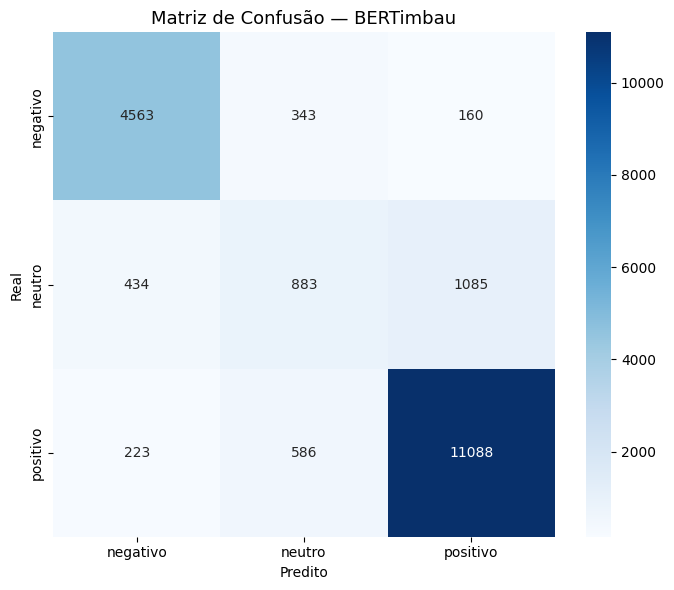

In [9]:
fig = plotar_matriz_confusao(y_test, y_test_pred, "BERTimbau")
plt.show()

## 7. Histórico de Treinamento

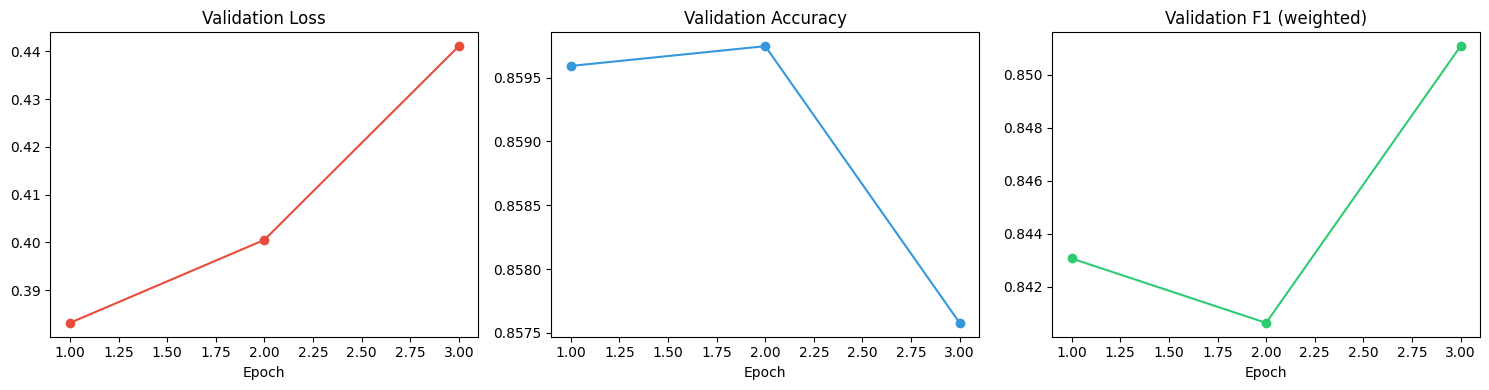

In [10]:
# Extrair métricas do log
log_history = trainer.state.log_history

eval_logs = [l for l in log_history if "eval_f1_weighted" in l]
if eval_logs:
    epochs = [l["epoch"] for l in eval_logs]
    f1s = [l["eval_f1_weighted"] for l in eval_logs]
    accs = [l["eval_accuracy"] for l in eval_logs]
    losses = [l["eval_loss"] for l in eval_logs]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(epochs, losses, "o-", color="#e74c3c")
    axes[0].set_title("Validation Loss")
    axes[0].set_xlabel("Epoch")

    axes[1].plot(epochs, accs, "o-", color="#3498db")
    axes[1].set_title("Validation Accuracy")
    axes[1].set_xlabel("Epoch")

    axes[2].plot(epochs, f1s, "o-", color="#2ecc71")
    axes[2].set_title("Validation F1 (weighted)")
    axes[2].set_xlabel("Epoch")

    plt.tight_layout()
    from src.config import FIGURES_DIR
    fig.savefig(FIGURES_DIR / "bert_training_history.png", dpi=150)
    plt.show()

## 8. Salvar Modelo Final

In [11]:
trainer.save_model(str(MODELS_DIR / "bert_sentiment_final"))
tokenizer.save_pretrained(str(MODELS_DIR / "bert_sentiment_final"))
print("Modelo BERTimbau salvo!")

Modelo BERTimbau salvo!


## Resumo

- BERTimbau fine-tuned por 3 épocas para sentimento ternário
- Métricas avaliadas no conjunto de teste
- Modelo salvo para inferência futura
- Próximo passo: **06_icl_claude.ipynb** (bônus)